# PSP analysis 

In this note, we analyze a dataset for Progressive Supranuclear Palsy (PSP), which includes RNA-Seq data from 25 PSP patients and 16 controls with total of 1675 ENS gene IDs.

- Our analysis begins with a 5-fold cross-validation using XGBoost, where we compute and plot the average AUC, specificity, sensitivity, and accuracy scores with standard deviation error bars.


In [130]:
import shap
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from collections import Counter
from pathlib import Path

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import os

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb


In [2]:
#os.getcwd()

'/home/ebri/Documenti/psp'

In [58]:
path1=Path("/Users/zainabnazari/psp/data")


In [146]:
w_psp_data=pd.read_csv(path1/"mydata_TMM_Norm_Log2_CPM_M1_filtered_STAR_align_HtSeq_top_2212_ParCor_Spearman_p_1pc.txt",delimiter='\t')
w_psp_data


,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
0,ENSG00000100422,6.506574,6.837920,6.772722,6.747701,6.618395,6.921674,6.755341,6.747092,6.777050,...,6.913361,6.919585,6.537452,6.594185,6.794908,6.809616,6.993349,6.760549,6.982361,6.642065
1,ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
2,ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
3,ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
4,ENSG00000252050,-0.762079,0.131687,-1.127767,-1.301907,-0.868301,-0.442867,0.335159,-0.225973,-0.536890,...,-0.736582,-0.423275,-0.086798,-0.232808,-0.514078,-0.229998,0.124654,-0.854666,-0.496920,-0.269930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,ENSG00000221025,-0.070314,-1.617697,0.628237,0.091830,-0.441282,0.981428,0.562096,1.085299,0.660590,...,-0.736582,-0.014826,0.535667,0.503862,0.723713,1.379158,0.507937,-0.354722,-0.078151,0.482193
1671,ENSG00000240401,1.567660,1.648616,0.932333,0.540061,0.250152,0.780836,0.531781,0.821393,0.591142,...,1.148520,0.784013,0.617561,0.684382,1.117865,1.094162,1.170846,1.672109,1.002999,0.411535
1672,ENSG00000157404,0.659065,1.979489,1.957161,1.472122,0.842484,1.993509,1.261467,1.803209,1.812397,...,1.900152,1.387776,1.868274,1.831922,1.720009,1.442404,0.810471,0.763945,0.733987,1.262041
1673,ENSG00000240808,-0.845117,-0.209798,-0.601399,-0.937647,-0.772187,-0.620955,-0.376459,0.274674,-0.701422,...,-1.328900,-0.778353,0.151786,0.141419,-0.923312,-0.181513,-1.938851,-1.906657,-1.089373,-0.005387


In [6]:
w_psp_data.set_index('ID', inplace=True)

In [7]:
w_psp_data


,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,CTR012,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000100422,6.506574,6.837920,6.772722,6.747701,6.618395,6.921674,6.755341,6.747092,6.777050,6.710424,...,6.913361,6.919585,6.537452,6.594185,6.794908,6.809616,6.993349,6.760549,6.982361,6.642065
ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,6.298489,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,-0.913524,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,0.244653,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
ENSG00000252050,-0.762079,0.131687,-1.127767,-1.301907,-0.868301,-0.442867,0.335159,-0.225973,-0.536890,0.055878,...,-0.736582,-0.423275,-0.086798,-0.232808,-0.514078,-0.229998,0.124654,-0.854666,-0.496920,-0.269930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000221025,-0.070314,-1.617697,0.628237,0.091830,-0.441282,0.981428,0.562096,1.085299,0.660590,0.934619,...,-0.736582,-0.014826,0.535667,0.503862,0.723713,1.379158,0.507937,-0.354722,-0.078151,0.482193
ENSG00000240401,1.567660,1.648616,0.932333,0.540061,0.250152,0.780836,0.531781,0.821393,0.591142,1.686714,...,1.148520,0.784013,0.617561,0.684382,1.117865,1.094162,1.170846,1.672109,1.002999,0.411535
ENSG00000157404,0.659065,1.979489,1.957161,1.472122,0.842484,1.993509,1.261467,1.803209,1.812397,1.750411,...,1.900152,1.387776,1.868274,1.831922,1.720009,1.442404,0.810471,0.763945,0.733987,1.262041


In [6]:
diagnosis_row = [0 if col.startswith('CTR') else 1 for col in w_psp_data.columns]
w_psp_data.loc['Diagnosis'] = diagnosis_row

In [8]:
full_data = w_psp_data.T

In [9]:
full_data

ID,ENSG00000100422,ENSG00000164941,ENSG00000250222,ENSG00000288772,ENSG00000252050,ENSG00000288833,ENSG00000122692,ENSG00000276216,ENSG00000115841,ENSG00000258302,...,ENSG00000198131,ENSG00000200563,ENSG00000267855,ENSG00000286787,ENSG00000112149,ENSG00000221025,ENSG00000240401,ENSG00000157404,ENSG00000240808,ENSG00000212445
CTR001,6.506574,6.119330,-0.228555,0.499942,-0.762079,-0.845117,6.141067,-0.070314,2.451738,-0.121157,...,3.456606,-0.538289,-0.173857,1.379317,2.576632,-0.070314,1.567660,0.659065,-0.845117,-0.609097
CTR002,6.837920,6.043177,0.080095,0.528018,0.131687,-1.059498,6.160372,0.131687,2.850967,0.365137,...,4.125328,-0.275485,-0.086768,1.194489,2.126602,-1.617697,1.648616,1.979489,-0.209798,0.928866
CTR003,6.772722,6.002901,-1.407259,-0.026939,-1.127767,-1.260755,6.214196,0.382818,2.618162,0.290766,...,4.313345,-1.006009,-0.285763,0.805017,3.429478,0.628237,0.932333,1.957161,-0.601399,0.086915
CTR004,6.747701,6.009847,-0.647067,0.419582,-1.301907,-1.447098,6.104073,0.241492,2.824680,-0.198320,...,4.018804,-1.998473,0.288118,1.934607,3.881109,0.091830,0.540061,1.472122,-0.937647,-0.647067
CTR005,6.618395,5.677839,-1.082175,0.295217,-0.868301,-0.441282,6.098313,0.338918,2.807547,0.155564,...,4.236536,-0.971278,0.203633,1.510855,2.768130,-0.441282,0.250152,0.842484,-0.772187,0.105838
CTR006,6.921674,5.911585,-0.361441,0.049184,-0.442867,-0.442867,6.006663,-0.529165,2.681860,-0.075142,...,4.021602,-0.718984,-0.620955,1.564073,2.407685,0.981428,0.780836,1.993509,-0.620955,-0.361441
CTR007,6.755341,6.057230,-0.021479,0.187412,0.335159,-0.496290,6.071130,-0.435131,2.807829,-0.265821,...,4.360416,-1.690426,0.022789,1.146132,3.236883,0.562096,0.531781,1.261467,-0.376459,0.299616
CTR009,6.747092,6.030343,-1.153149,-0.142911,-0.225973,-0.859911,6.177992,0.148449,2.934526,0.010112,...,4.160337,-0.732983,0.274674,1.248033,2.382058,1.085299,0.821393,1.803209,0.274674,0.010112
CTR010,6.777050,6.071518,-1.100401,-0.255263,-0.536890,-1.100401,6.174526,-0.019736,2.882703,-0.536890,...,4.359278,-1.100401,0.182682,1.430323,3.159530,0.660590,0.591142,1.812397,-0.701422,-0.536890
CTR012,6.710424,6.298489,-0.913524,0.244653,0.055878,-1.374931,6.080375,0.411560,2.648663,-0.161369,...,3.967512,-1.374931,-0.728468,0.934619,2.580200,0.934619,1.686714,1.750411,0.330519,-0.728468


In [38]:
# Assuming full_data is your DataFrame
# The index column is the patient names, diagnosis is the target, and gene columns are the features

# Separate features (X) and target (y)
X = full_data.drop(columns=['Diagnosis'])  # Gene expression data (features)
y = full_data['Diagnosis']  # Diagnosis (target)

# Split the dataset into training and testing sets (80% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We use probabilities for the positive class (1)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.2f}")


AUC Score: 0.60


In [ ]:
# TOP Genes

Top 20 Important Genes:
                 Gene  Importance
246   ENSG00000225579    0.173858
1401  ENSG00000251703    0.148214
985   ENSG00000168255    0.140914
781   ENSG00000257390    0.112165
422   ENSG00000162461    0.097633
113   ENSG00000130305    0.093857
181   ENSG00000122783    0.049569
0     ENSG00000100422    0.045556
1369  ENSG00000099365    0.039282
791   ENSG00000189223    0.035680
25    ENSG00000117308    0.026971
1252  ENSG00000281357    0.016736
16    ENSG00000238121    0.015470
165   ENSG00000288542    0.004095
1110  ENSG00000106976    0.000000
1117  ENSG00000271122    0.000000
1122  ENSG00000228495    0.000000
1121  ENSG00000219085    0.000000
1120  ENSG00000203286    0.000000
1119  ENSG00000182973    0.000000


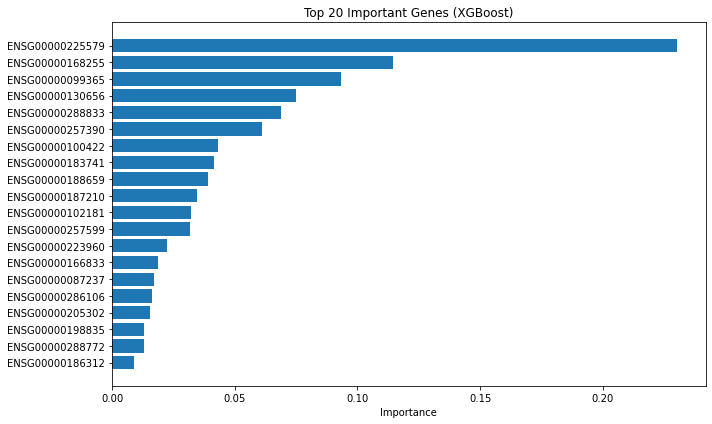

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = pd.DataFrame({
    'Gene': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Get the top 20 most important genes
top_20_genes = feature_importances.head(20)

print("Top 20 Important Genes:")
print(top_20_genes)

# Optional: plot the top 20 for visualization
top_20 = top_50_genes.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_20['Gene'][::-1], top_20['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Important Genes (XGBoost)")
plt.tight_layout()
plt.show()


# Pearson Correlated with Clinical

In [13]:
pearson_c=pd.read_csv(path1/"pearson_clinical.csv",delimiter=',')
pearson_c

,var1,var2,corr,corr_CI5%,corr_CI95%,pvalue,FDR_corrected_Pval,Bonferroni_corrected_Pval,N_non_Null_elements,ParCor,ParCor_Pval,ParCor_FDR,ParCor_Bonferroni
0,ENSG00000001629,nms_mood_cognition,"-0,6166624861",NaN,NaN,"1,03E-03","9,99E-01","1,00E+00",25,"-0,5646153846","3,82E-03","1,00E+00","1,00E+00"
1,ENSG00000002330,nms_gastrointestinal,"-0,4816964625",NaN,NaN,"1,48E-02","9,99E-01","1,00E+00",25,"-0,6607692308","4,47E-04","1,00E+00","1,00E+00"
2,ENSG00000002822,nms_perceptual_hallucinations,"0,5091784683",NaN,NaN,"9,33E-03","9,99E-01","1,00E+00",25,"0,5384615385","6,18E-03","1,00E+00","1,00E+00"
3,ENSG00000003096,psp_stage,"0,5529597126",NaN,NaN,"4,15E-03","9,99E-01","1,00E+00",25,"0,5438461538","5,61E-03","1,00E+00","1,00E+00"
4,ENSG00000004399,nms_gastrointestinal,"0,5861282556",NaN,NaN,"2,08E-03","9,99E-01","1,00E+00",25,"0,5792307692","2,87E-03","1,00E+00","1,00E+00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,ENSG00000293465,nms_gastrointestinal,"0,5522168247",NaN,NaN,"4,21E-03","9,99E-01","1,00E+00",25,"0,5146153846","9,32E-03","1,00E+00","1,00E+00"
2208,ENSG00000293468,psp_scale_ocular_motor_exam,"-0,5232298447",NaN,NaN,"7,28E-03","9,99E-01","1,00E+00",25,"-0,5430769231","5,69E-03","1,00E+00","1,00E+00"
2209,ENSG00000293491,psp_scale_bulbar_exam,"0,2362387817",NaN,NaN,"2,56E-01","9,99E-01","1,00E+00",25,"0,5107692308","9,93E-03","1,00E+00","1,00E+00"
2210,ENSG00000293497,nms_cardiovascular_falls,"0,5179117146",NaN,NaN,"8,00E-03","9,99E-01","1,00E+00",25,"0,5246153846","7,87E-03","1,00E+00","1,00E+00"


In [14]:
pearson_c.columns

Index(['var1', 'var2', 'corr', 'corr_CI5%', 'corr_CI95%', 'pvalue',
       'FDR_corrected_Pval', 'Bonferroni_corrected_Pval',
       'N_non_Null_elements', 'ParCor', 'ParCor_Pval', 'ParCor_FDR',
       'ParCor_Bonferroni'],
      dtype='object')

In [35]:
pearson_c['var1'].duplicated().any()


True

In [30]:
unique = pearson_c['var2'].unique()
unique_list =list(unique)
unique_list

['nms_mood_cognition',
 'nms_gastrointestinal',
 'nms_perceptual_hallucinations',
 'psp_stage',
 'psp_scale_bulbar_exam',
 'nms_cardiovascular_falls',
 'nms_sleep_fatigue',
 'psp_scale_ocular_motor_exam',
 'nms_urinary',
 'psp_scaleHist',
 'TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait',
 'psp_scale_mental_exam',
 'TOTAL_nms',
 'psp_scale_gait',
 'nms_attention_memory',
 'psp_scale_limb_exam',
 'nms_miscellaneous',
 'nms_sexual']

In [31]:
len(unique_list)

18

In [37]:
grouped =pearson_c.groupby('var2')['var1'].apply(list)


In [52]:
grouped

var2
TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait    [ENSG00000012211, ENSG00000026036, ENSG0000007...
TOTAL_nms                                        [ENSG00000026036, ENSG00000048052, ENSG0000007...
nms_attention_memory                             [ENSG00000047230, ENSG00000072682, ENSG0000007...
nms_cardiovascular_falls                         [ENSG00000005889, ENSG00000007516, ENSG0000003...
nms_gastrointestinal                             [ENSG00000002330, ENSG00000004399, ENSG0000000...
nms_miscellaneous                                [ENSG00000055732, ENSG00000061337, ENSG0000007...
nms_mood_cognition                               [ENSG00000001629, ENSG00000017260, ENSG0000004...
nms_perceptual_hallucinations                    [ENSG00000002822, ENSG00000005893, ENSG0000004...
nms_sexual                                       [ENSG00000166428, ENSG00000177082, ENSG0000026...
nms_sleep_fatigue                                [ENSG00000008128, ENSG00000064989, ENSG0000010...
nms_u

In [42]:
result_df = grouped.to_frame().T
result_df.columns

Index(['TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait', 'TOTAL_nms',
       'nms_attention_memory', 'nms_cardiovascular_falls',
       'nms_gastrointestinal', 'nms_miscellaneous', 'nms_mood_cognition',
       'nms_perceptual_hallucinations', 'nms_sexual', 'nms_sleep_fatigue',
       'nms_urinary', 'psp_scaleHist', 'psp_scale_bulbar_exam',
       'psp_scale_gait', 'psp_scale_limb_exam', 'psp_scale_mental_exam',
       'psp_scale_ocular_motor_exam', 'psp_stage'],
      dtype='object', name='var2')

In [66]:
whole_clinical_name= list(result_df)
whole_clinical_name

['TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait',
 'TOTAL_nms',
 'nms_attention_memory',
 'nms_cardiovascular_falls',
 'nms_gastrointestinal',
 'nms_miscellaneous',
 'nms_mood_cognition',
 'nms_perceptual_hallucinations',
 'nms_sexual',
 'nms_sleep_fatigue',
 'nms_urinary',
 'psp_scaleHist',
 'psp_scale_bulbar_exam',
 'psp_scale_gait',
 'psp_scale_limb_exam',
 'psp_scale_mental_exam',
 'psp_scale_ocular_motor_exam',
 'psp_stage']

In [49]:
len(clinic_1)

1

In [50]:
data_norm = pd.read_csv(path1/"PSP_mydata_TMM_Norm_Log2_CPM_filtered.txt",delimiter='\t')
data_norm


,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
0,ENST00000000233,3.129980,3.796351,3.263256,3.290152,0.983169,3.388799,4.049714,4.270522,2.090801,...,3.693597,3.261537,4.436807,3.518451,3.196175,4.031487,2.674302,2.963549,3.011017,3.584869
1,ENST00000000412,3.394490,4.178982,3.462958,3.342894,3.617388,3.053690,3.932178,3.357748,3.766091,...,4.425315,3.202413,3.638255,3.629440,3.183476,3.712981,4.227697,3.430837,3.264506,3.045067
2,ENST00000000442,0.009540,-3.489044,3.994716,2.894300,0.549971,2.456112,0.372680,0.698243,3.777794,...,4.731152,3.076359,4.051876,3.203626,3.742230,-1.029328,3.406843,2.709123,-3.558343,-3.578372
3,ENST00000001008,4.255611,3.873537,4.249932,4.323465,4.280267,3.789500,4.082619,4.268560,4.068837,...,3.825032,4.273899,3.792653,6.212525,4.266448,4.329819,4.543984,4.311673,4.251317,4.057489
4,ENST00000002125,0.713203,-4.354783,0.153984,1.725431,0.308533,1.793578,2.159500,2.527691,0.711250,...,0.943280,2.683452,-1.209353,2.024723,2.222589,1.355229,-3.298161,1.585846,-0.219065,-2.549481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52427,ENST00000652763,2.447150,-0.163557,0.893186,-1.077590,1.098205,-0.358939,2.497493,2.353547,1.621908,...,-0.982926,-1.521297,-1.526075,2.106222,-0.230940,0.608012,-1.451680,2.365984,0.574649,-0.234110
52428,ENST00000652764,-0.145578,0.416720,0.825518,0.265794,0.549971,1.003608,0.017716,0.202175,-0.154481,...,-0.858148,-0.365448,0.262601,-0.858810,-0.618654,0.636521,0.143539,0.579755,0.626048,-0.015123
52429,ENST00000652767,-1.122357,1.149925,1.190791,0.469279,-0.462554,0.553468,-1.107281,-1.950678,-1.701611,...,-1.849891,-1.521297,-0.149932,0.610617,0.727079,0.664478,0.395895,-0.525258,1.449796,0.999965
52430,ENST00000652769,3.940725,4.209075,4.183916,4.198651,4.287861,3.874418,4.352723,4.043830,4.190573,...,4.122495,4.402049,3.991305,3.916028,4.024463,4.039515,3.970282,4.280043,4.236234,4.225433


In [131]:
result_dict = {}

# grouped is a Series: index = clinical_measure, values = list of ENSG IDs
for clinical_measure, gene_list in grouped.items():
    # Filter rows from data_norm using the list of ENSG IDs
    filtered_df = w_psp_data[w_psp_data['ID'].isin(gene_list)].copy()
    
    # Store the filtered DataFrame in a dictionary
    result_dict[clinical_measure] = filtered_df


In [107]:
TOTAL_nms = result_dict['TOTAL_nms']  # shows genes and case/control values related to 'TOTAL_nms'
TOTAL_nms

,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
1,ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
2,ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
3,ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
7,ENSG00000276216,-0.070314,0.131687,0.382818,0.241492,0.338918,-0.529165,-0.435131,0.148449,-0.019736,...,-0.512094,1.033729,-0.086798,-0.739458,0.797344,0.300398,-0.249103,0.170644,0.510533,0.258904
8,ENSG00000115841,2.451738,2.850967,2.618162,2.824680,2.807547,2.681860,2.807829,2.934526,2.882703,...,2.757843,2.906443,2.527979,2.191613,2.492908,2.746358,2.732785,2.610439,2.631717,2.520201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,ENSG00000178440,0.981724,0.742319,0.870079,0.615130,0.811797,0.884616,0.500816,0.940450,0.965083,...,0.386775,0.850610,0.905311,1.077953,1.228479,0.763631,0.230435,1.288338,1.330880,1.467570
1662,ENSG00000105607,3.412602,3.257385,3.573171,3.470431,3.896088,3.616927,3.490418,3.535737,3.609296,...,3.646549,3.943781,3.778874,3.659075,3.817963,3.427736,3.280398,3.599181,3.873100,3.852949
1663,ENSG00000164308,5.779821,6.585569,6.912961,6.728811,7.271979,6.223400,6.720907,6.615353,6.792602,...,6.655864,6.913756,5.707355,6.684440,5.714154,6.464476,5.777073,6.902640,6.934105,6.734063
1664,ENSG00000103274,3.848842,3.711846,3.472014,3.822919,4.106670,3.746545,3.893493,3.968202,3.743380,...,4.254837,3.782569,3.831303,3.701613,3.669002,3.631446,3.917191,3.710637,3.592358,3.763577


In [132]:
for name in whole_clinical_name:
    globals()[name] = result_dict.get(name)


In [79]:
df =TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait

In [133]:
df=nms_urinary

In [139]:
df = psp_scale_ocular_motor_exam

In [142]:
df = TOTAL_nms
df

,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
1,ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
2,ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
3,ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
7,ENSG00000276216,-0.070314,0.131687,0.382818,0.241492,0.338918,-0.529165,-0.435131,0.148449,-0.019736,...,-0.512094,1.033729,-0.086798,-0.739458,0.797344,0.300398,-0.249103,0.170644,0.510533,0.258904
8,ENSG00000115841,2.451738,2.850967,2.618162,2.824680,2.807547,2.681860,2.807829,2.934526,2.882703,...,2.757843,2.906443,2.527979,2.191613,2.492908,2.746358,2.732785,2.610439,2.631717,2.520201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,ENSG00000178440,0.981724,0.742319,0.870079,0.615130,0.811797,0.884616,0.500816,0.940450,0.965083,...,0.386775,0.850610,0.905311,1.077953,1.228479,0.763631,0.230435,1.288338,1.330880,1.467570
1662,ENSG00000105607,3.412602,3.257385,3.573171,3.470431,3.896088,3.616927,3.490418,3.535737,3.609296,...,3.646549,3.943781,3.778874,3.659075,3.817963,3.427736,3.280398,3.599181,3.873100,3.852949
1663,ENSG00000164308,5.779821,6.585569,6.912961,6.728811,7.271979,6.223400,6.720907,6.615353,6.792602,...,6.655864,6.913756,5.707355,6.684440,5.714154,6.464476,5.777073,6.902640,6.934105,6.734063
1664,ENSG00000103274,3.848842,3.711846,3.472014,3.822919,4.106670,3.746545,3.893493,3.968202,3.743380,...,4.254837,3.782569,3.831303,3.701613,3.669002,3.631446,3.917191,3.710637,3.592358,3.763577


In [144]:
df = TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait
df

,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
9,ENSG00000258302,-0.121157,0.365137,0.290766,-0.198320,0.155564,-0.075142,-0.265821,0.010112,-0.536890,...,0.270737,0.395250,-0.729909,1.315599,-0.923312,0.265847,1.322080,0.015850,0.673595,-0.455591
34,ENSG00000277383,-0.121157,-0.209798,0.086915,0.143462,0.381333,0.319915,0.335159,-0.142911,0.274150,...,1.010619,0.204733,0.356457,-0.033595,-0.923312,-0.280171,0.589723,0.242227,-0.242992,0.374864
35,ENSG00000146674,1.817584,2.738991,1.765277,1.625246,2.660302,1.211724,1.845859,2.280391,2.404685,...,2.083296,1.387776,2.569726,1.519580,1.059206,2.091621,2.411507,1.288338,3.118765,1.301654
64,ENSG00000114354,5.885011,5.760385,5.505587,5.756767,5.887333,5.609792,5.960973,5.718134,5.915131,...,5.882731,5.813154,5.824068,5.698954,5.479870,5.948595,5.976481,5.781468,5.944839,5.861645
71,ENSG00000250490,-2.366757,-2.248811,-1.407259,-0.737576,-0.517167,-0.824164,-0.697057,-0.142911,-0.887163,...,-1.328900,-0.014826,-1.205537,-1.080215,-0.704233,-0.561105,-0.754887,-1.189417,-1.739376,-1.012949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,ENSG00000221025,-0.070314,-1.617697,0.628237,0.091830,-0.441282,0.981428,0.562096,1.085299,0.660590,...,-0.736582,-0.014826,0.535667,0.503862,0.723713,1.379158,0.507937,-0.354722,-0.078151,0.482193
1671,ENSG00000240401,1.567660,1.648616,0.932333,0.540061,0.250152,0.780836,0.531781,0.821393,0.591142,...,1.148520,0.784013,0.617561,0.684382,1.117865,1.094162,1.170846,1.672109,1.002999,0.411535
1672,ENSG00000157404,0.659065,1.979489,1.957161,1.472122,0.842484,1.993509,1.261467,1.803209,1.812397,...,1.900152,1.387776,1.868274,1.831922,1.720009,1.442404,0.810471,0.763945,0.733987,1.262041
1673,ENSG00000240808,-0.845117,-0.209798,-0.601399,-0.937647,-0.772187,-0.620955,-0.376459,0.274674,-0.701422,...,-1.328900,-0.778353,0.151786,0.141419,-0.923312,-0.181513,-1.938851,-1.906657,-1.089373,-0.005387


In [147]:
df = w_psp_data
df

,ID,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
0,ENSG00000100422,6.506574,6.837920,6.772722,6.747701,6.618395,6.921674,6.755341,6.747092,6.777050,...,6.913361,6.919585,6.537452,6.594185,6.794908,6.809616,6.993349,6.760549,6.982361,6.642065
1,ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
2,ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
3,ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
4,ENSG00000252050,-0.762079,0.131687,-1.127767,-1.301907,-0.868301,-0.442867,0.335159,-0.225973,-0.536890,...,-0.736582,-0.423275,-0.086798,-0.232808,-0.514078,-0.229998,0.124654,-0.854666,-0.496920,-0.269930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,ENSG00000221025,-0.070314,-1.617697,0.628237,0.091830,-0.441282,0.981428,0.562096,1.085299,0.660590,...,-0.736582,-0.014826,0.535667,0.503862,0.723713,1.379158,0.507937,-0.354722,-0.078151,0.482193
1671,ENSG00000240401,1.567660,1.648616,0.932333,0.540061,0.250152,0.780836,0.531781,0.821393,0.591142,...,1.148520,0.784013,0.617561,0.684382,1.117865,1.094162,1.170846,1.672109,1.002999,0.411535
1672,ENSG00000157404,0.659065,1.979489,1.957161,1.472122,0.842484,1.993509,1.261467,1.803209,1.812397,...,1.900152,1.387776,1.868274,1.831922,1.720009,1.442404,0.810471,0.763945,0.733987,1.262041
1673,ENSG00000240808,-0.845117,-0.209798,-0.601399,-0.937647,-0.772187,-0.620955,-0.376459,0.274674,-0.701422,...,-1.328900,-0.778353,0.151786,0.141419,-0.923312,-0.181513,-1.938851,-1.906657,-1.089373,-0.005387


Mean CV AUC: 0.616 ± 0.095
Test AUC: 0.650


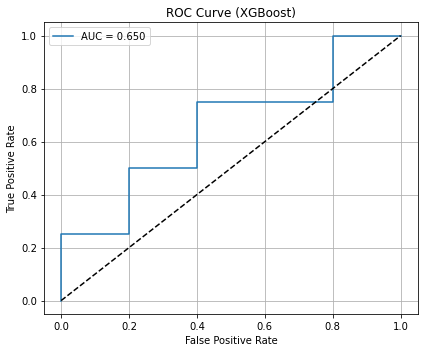

In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- Step 1: Load and reformat data ---

# Load raw data
#df = pd.read_csv("your_file.csv", index_col=1)  # Assume column 1 has ENSG IDs
df = df.drop(columns=["ID"])  # Drop 'ID' column (row index now is ENSG ID)

# Transpose so samples are rows, genes are columns
df = df.T  # Now shape is (samples, genes)

# Create labels from sample names
labels = df.index.to_series().apply(lambda x: 0 if "CTR" in x else 1).values

# Now: df is your X (features), labels is your y
X = df.values
y = labels
sample_names = df.index
gene_names = df.columns

# --- Step 2: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- Step 3: Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 4: Define XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# --- Step 5: Cross-validation AUC ---
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_auc_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
print(f"Mean CV AUC: {np.mean(cv_auc_scores):.3f} ± {np.std(cv_auc_scores):.3f}")

# --- Step 6: Train on full training set ---
xgb_model.fit(X_train_scaled, y_train)

# --- Step 7: Test set evaluation ---
y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC: {test_auc:.3f}")

# --- Step 8: Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [124]:
df=nms_urinary

In [125]:


# Set 'ID' column (ENSG IDs) as index
df.set_index("ID", inplace=True)

# Transpose: samples become rows, genes become columns
df = df.T

# Now gene IDs are column names
gene_names = df.columns  # These are ENSG IDs from 'ID' column


In [126]:
y = df.index.to_series().apply(lambda x: 0 if "CTR" in x else 1).values
X = df.values  # shape: (samples, genes)


In [127]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Feature importance
importances = xgb_model.feature_importances_
importance_series = pd.Series(importances, index=gene_names)

# Top 10 by importance → then sort by ENSG ID
top_10_genes = importance_series.sort_values(ascending=False).head(10)
top_10_genes_sorted = top_10_genes.sort_index()

# Display
print("Top 10 genes by importance, sorted by ENSG ID:")
print(top_10_genes_sorted)


Top 10 genes by importance, sorted by ENSG ID:
ID
ENSG00000100320    0.053318
ENSG00000136830    0.042515
ENSG00000143434    0.083834
ENSG00000149091    0.171332
ENSG00000168255    0.046929
ENSG00000179094    0.042227
ENSG00000180357    0.107069
ENSG00000223496    0.048018
ENSG00000260228    0.036843
ENSG00000283341    0.100983
dtype: float32


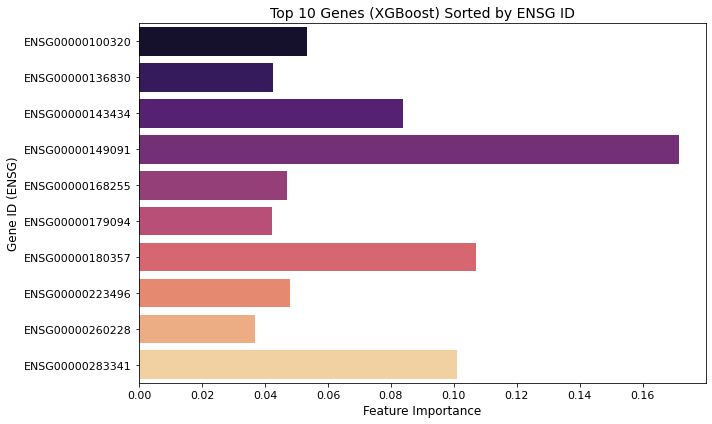

In [128]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_genes_sorted.values, y=top_10_genes_sorted.index, palette="magma")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Gene ID (ENSG)", fontsize=12)
plt.title("Top 10 Genes (XGBoost) Sorted by ENSG ID", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


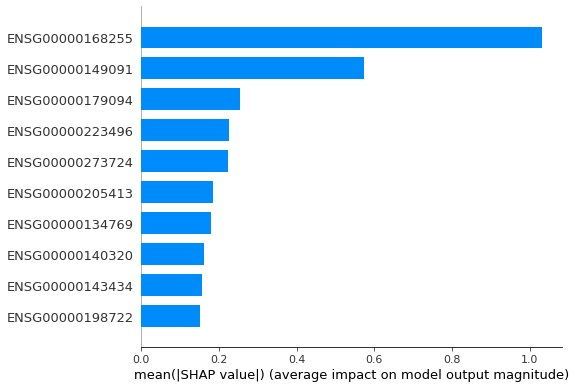

In [129]:
import shap

explainer = shap.Explainer(xgb_model, X_train_scaled, feature_names=gene_names)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, features=X_test_scaled, feature_names=gene_names, 
                  plot_type="bar", max_display=10)


In [ ]:
s